In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa

/home/zac/.local/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
!pip install --user matplotlib

### Data loading/preprocessing

In [3]:
with open('large_dataset.pickle', 'rb') as f:
    d = pickle.load(f)
    keystrokes, grades = d['logs'], d['grades']

In [4]:
grades = grades.set_index(['semester', 'class', 'student'])
keystrokes = keystrokes.set_index(['semester', 'class', 'student'])
keystrokes.time_to_deadline = keystrokes.time_to_deadline.dt.total_seconds()

Filter out students for which we don't have a final grade::

In [5]:
mask = ~grades.grade.isna()
grades = grades[mask]
keystrokes = keystrokes[keystrokes.index.isin(grades.index)]

In [6]:
# One-hot encode the event type
encoder = OneHotEncoder(sparse=False)
one_hot_type = encoder.fit_transform(keystrokes.event_type.to_numpy().reshape(-1,1)); one_hot_type.shape
for i, cat in enumerate(encoder.categories_[0]):
    keystrokes[cat] = one_hot_type[:,i]

In [7]:
# Normalise the time_to_deadline per excercise
keystrokes['normalised_deadlines'] = keystrokes.groupby(['semester', 'class', 'student', 'assignment_excercise']).time_to_deadline.apply(lambda group: group / group.max())

In [8]:
keystrokes_np = keystrokes.groupby(['semester', 'class', 'student', 'assignment_excercise']).apply(lambda g: g[['normalised_deadlines', *encoder.categories_[0]]].to_numpy())

In [9]:
grades_reindexed = grades.loc[keystrokes_np.index.droplevel(-1)]; grades_reindexed

grade
semester class student       
2016-1   102   1278      2.59
               1278      2.59
               1278      2.59
               1278      2.59
               1278      2.59
...                       ...
2021-2   357   6193      0.02
               6193      0.02
               6193      0.02
               6193      0.02
               6193      0.02

[32972 rows x 1 columns]

### Model

In [10]:
def ragged_normalise(ragged):
    tensor = ragged.to_tensor()
    normalised = tf.linalg.normalize(tensor, axis=None)
    tensor = tf.convert_to_tensor(normalised[0])
    return tf.RaggedTensor.from_tensor(tensor, padding=0.0)

In [11]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [12]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    n_classes=1
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [13]:
model = build_model(
    (None, 7),
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

2022-05-19 21:32:22.063266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 21:32:22.483689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


In [35]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  return r2


In [40]:
model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)

In [15]:
#model.summary()

### Split

In [16]:
for semester in keystrokes_np.index.get_level_values(0).unique():
    print(semester, keystrokes.loc[semester].index.get_level_values('student').unique().shape)

2016-1 (354,)
2016-2 (143,)
2017-1 (417,)
2017-2 (141,)
2018-1 (407,)
2018-2 (147,)
2019-1 (408,)
2019-2 (242,)
2021-1 (161,)
2021-2 (148,)


In [17]:
keras.__version__

'2.9.0'

In [18]:
sequence_max = 5000

<AxesSubplot:>

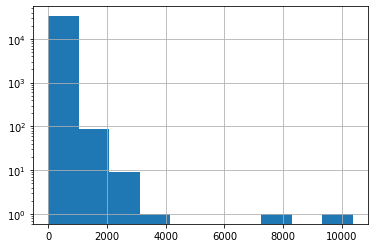

In [19]:
keystrokes.groupby(['semester', 'class', 'student', 'assignment_excercise']).time_to_deadline.count().hist(log=True)

In [20]:
x_train = keystrokes_np.loc[['2016-1', '2016-2', '2017-1', '2017-2', '2018-1', '2018-2', '2019-1', '2019-2']]
x_train = tf.keras.utils.pad_sequences(x_train, maxlen=sequence_max, dtype=float, padding='post', truncating='post')
y_train = grades_reindexed.loc[['2016-1', '2016-2', '2017-1', '2017-2', '2018-1', '2018-2', '2019-1', '2019-2']].to_numpy()

x_val = keystrokes_np.loc['2021-1']
x_val = tf.keras.utils.pad_sequences(x_val, maxlen=sequence_max, dtype=float, padding='post', truncating='post')
y_val = grades_reindexed.loc['2021-1'].to_numpy()

x_test = keystrokes_np.loc['2021-2']
x_test = tf.keras.utils.pad_sequences(x_test, maxlen=sequence_max, dtype=float, padding='post', truncating='post')
y_test = grades_reindexed.loc['2021-2'].to_numpy()

### Training

In [41]:
import gc; gc.collect()

16998

In [43]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0,
          write_graph=True),
    keras.callbacks.ModelCheckpoint('checkpoint')
]

In [ ]:
model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    epochs=30,
    batch_size=2,
    callbacks=callbacks,
)

Epoch 1/30
12882/14230 [==========================>...] - ETA: 4:39 - loss: 24.0389 - mean_squared_error: 24.0389